# Model Extraction Attack Example Against CIFAR-10 CNN

This notebook demonstrates how to simulate a model extraction attack against our ImRecs Service using a CIFAR-10 CNN as an example.
We will use ART (Adversarial Robustness Toolbox) to perform the attack.

## Setup the Environment and Import Necessary Packages

First, we need to set up the environment and import the necessary packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import keras
from keras import layers, models
from art.estimators.classification import KerasClassifier
from art.attacks.extraction import CopycatCNN, KnockoffNets
from art.utils import load_cifar10

# ART complains unless you have disabled eager execution
tf.compat.v1.disable_eager_execution()

2024-06-16 16:34:17.835004: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-16 16:34:17.835035: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-16 16:34:17.835959: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Load the Target Model

Next, we load the target model that we want to attack.

In [4]:
# Load the target model
from keras.models import load_model
victim_model = load_model('../models/simple-cifar10.h5')

Instructions for updating:
Colocations handled automatically by placer.


## Load and Preprocess CIFAR-10 Dataset

We load the CIFAR-10 dataset and preprocess it by scaling the pixel values to be between 0 and 1.

In [5]:
# Load CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels), _, _ = load_cifar10()

# Preprocessing - scale pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0
cifar10_class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

(50000, 32, 32, 3) (50000, 10) (10000, 32, 32, 3) (10000, 10)


## Define and Compile Surrogate Model

We define a simple CNN architecture and compile it. This model will be used as the surrogate for ART to train and make the extracted model.

In [21]:
# Define a simple CNN architecture
def create_model():
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))  # Dropout layer added
    model.add(layers.Dense(10, activation='softmax'))
    return model

# Create and compile surrogate (extracted) model
surrogate_model = create_model()
surrogate_model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

## Wrap Models Using ART's KerasClassifier

We wrap the victim and surrogate models using ART's `KerasClassifier` interface.

In [22]:
# Wrap the models using ART's KerasClassifier
victim_art_model = KerasClassifier(model=victim_model, clip_values=(0, 1), use_logits=False)
surrogate_art_model = KerasClassifier(model=surrogate_model, clip_values=(0, 1), use_logits=False)

## Create the CopycatCNN Extraction Attack

We create the CopycatCNN extraction attack using the ART library.

In [23]:
# Create the CopycatCNN extraction attack
sample_size = 5000
attack = CopycatCNN(victim_art_model, batch_size_fit=64, batch_size_query=64, nb_epochs=10, nb_stolen=sample_size, use_probability=True)

## Select Samples for the Attack

We randomly select samples from the test dataset to use for the attack.

In [24]:
# Select the samples to use for the attack
indices = np.random.permutation(len(test_images))
x_extraction = test_images[indices[:sample_size]]
y_extraction = test_labels[indices[:sample_size]]
x_test = test_images[indices[sample_size:]]
y_test = test_labels[indices[sample_size:]]

## Stage the Attack and Extract the Model

We stage the attack and extract the model using the `extract` method from the attack object.

In [25]:
# Stage the attack and extract the model
stolen_classifier = attack.extract(x_extraction, thieved_classifier=surrogate_art_model)

## Evaluate the Extracted Surrogate Model

We evaluate the extracted surrogate model to determine its accuracy.

In [26]:
# Evaluate the extracted surrogate model
acc = surrogate_model.evaluate(test_images, test_labels)[1]
print(f'Extracted model accuracy: {acc}')

Extracted model accuracy: 0.10000000149011612


## Test with Unseen Data

We test the surrogate model with some further unseen data using helper functions to display the image and make predictions.

(0, 'airplane')
Predicted label: 4, Class name: deer


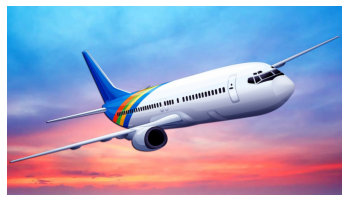

In [17]:
# Helper functions for predicting and displaying images
def predict(model, img):
    pred = model.predict(np.array([img]))
    label = np.argmax(pred, axis=1)[0]
    class_name = cifar10_class_names[label]
    return label, class_name

def show_image(img, size=1.2):
    if size > 0:
        plt.figure(figsize=(size, size), dpi=80)
    plt.imshow(img)
    plt.axis('off')

# Example of using the predict and show_image functions
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
# Load the image you want to test
img_original = Image.open('../images/airplane.jpg')
show_image(img_original, size=-1)
img_resized = img_original.resize((32,32))
img_data = img_to_array(img_resized)
print(predict(victim_model,img_data))
label, class_name = predict(surrogate_model, img_data)
print(f'Predicted label: {label}, Class name: {class_name}')

The attack is not succesful but demonstrates the techniques to use.  You will need to introduce a more complex surrogate model and experinment with parameters to get better results 